In [1]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

In [2]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = "cpu"
seed_torch(2023)

In [3]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.filter_ages(ALL_data,18) 




            orginal   removed diagnose NaN
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal      removed ID NaN   
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal   filtered department 
   nums      199995          45571        
              HTN             NHTN        
   nums       3273           42298        


            orginal      filtered ages    
   nums      45571           43570        
              HTN             NHTN        
   nums       3220           40350        


In [4]:
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.correct_label(ALL_data)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')



            orginal            QC         
   nums      43570           15344        
              HTN             NHTN        
   nums       1477           13867        


     reset num:       10  
  ERR labels num:     27  
            orginal      correct label    
   nums      15344           15344        
              HTN             NHTN        
   nums       1513           13831        


   ERR ages num:      831 
            orginal       correct age     
   nums      15344           15344        
              HTN             NHTN        
   nums       1513           13831        


            orginal    remove diagnose起搏  
   nums      15344           15278        
              HTN             NHTN        
   nums       1494           13784        
           remove HTN     remove NHTN     
   nums        19              47         


            orginal    remove diagnose房颤  
   nums      15278           14747        
              HTN             NHTN        
   num

In [5]:
ALL_data[ALL_data['label'] == 0]['住院号'].unique().__len__()
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()

## 常规操作

In [ ]:
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)

In [ ]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230322_030450/20230322_030450/BestF1_0.pt'
save_root = Models_path[:-3]+'/'    
layervalue_root = save_root+'/layervalue/'    
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore    
criterion = torch.nn.CrossEntropyLoss()    
testmodel = NET[0].to(DEVICE)    
testmodel.load_state_dict(torch.load(Models_path))    
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)      
y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [ ]:
np.array(y_out).shape

In [ ]:
test_df_save = test_df.copy()
test_df_save['predict HTN possibility'] = np.array(y_out)[:,1]
print(test_df_save.head)

In [ ]:
test_df_save[test_df_save['label']==1].__len__()

In [ ]:
test_df_save.to_csv('./test.csv',encoding='utf_8_sig')

In [ ]:

ALL_data.columns

In [ ]:
duplicated_HTN_df = ALL_data[ALL_data.duplicated(subset=['ID'], keep=False) & (ALL_data['label']==1)& ( ~ ALL_data['检查时间'].isnull()) ]

In [ ]:
duplicated_HTN_df.__len__()

In [ ]:
duplicated_HTN_df['检查时间'] = pd.to_datetime(duplicated_HTN_df['检查时间'])

In [ ]:
duplicated_HTN_df['date_diff'] = duplicated_HTN_df.groupby('ID')['检查时间'].apply(lambda x:abs( x.diff()).dt.total_seconds())

In [ ]:
duplicated_HTN_ID_list_buffer = list(duplicated_HTN_df[duplicated_HTN_df['date_diff']>(31536000/2)]['ID'])
print(duplicated_HTN_ID_list_buffer.__len__())

In [ ]:
duplicated_HTN_df= ALL_data[ALL_data['ID'].isin(duplicated_HTN_ID_list_buffer)].copy()
duplicated_HTN_dataset = ECGHandle.ECG_Dataset(data_root,duplicated_HTN_df,preprocess = True)

In [ ]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230322_030450/20230322_030450/BestF1_0.pt'
save_root = Models_path[:-3]+'/'    
layervalue_root = save_root+'/layervalue/'    
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore    
criterion = torch.nn.CrossEntropyLoss()    
testmodel = NET[0].to(DEVICE)    
testmodel.load_state_dict(torch.load(Models_path))    
duplicated_HTN_dataloader = Data.DataLoader(dataset=duplicated_HTN_dataset, batch_size=1, shuffle=False)      
y_true,y_pred,y_out,test_loss,test_acc = eval_model(duplicated_HTN_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [ ]:
duplicated_HTN_df['predict HTN possibility'] = np.array(y_out)[:,1]

In [ ]:
duplicated_HTN_df[duplicated_HTN_df['predict HTN possibility']<0.5]['ID'].unique().tolist()

In [ ]:
duplicated_HTN_df.to_csv('./duplicated_HTN_间隔半年以上.csv',encoding='utf_8_sig')

In [ ]:
jpg_path = './jpg/duplicated_HTN/'
for index in range(duplicated_HTN_dataset.__len__()):#test_dataset.__len__()
    info =duplicated_HTN_dataset.infos.iloc[index]
    file_name = info['ID']+'_'+info['ECGFilename']
    ID = info['ID']
    date = info['检查时间']
    age = info['age']
    label = info['label']
    ECG,labels = duplicated_HTN_dataset.__getitem__(index)
    ECG = ECG*5000 #恢复
    ecg_plot.plot(ECG*4.88/1000, sample_rate = 500, title = 'ID:'+str(ID)+' '+ 'label: '+ str(label) +' '+'Date: '+str(date)+' '+'age: '+str(age)  ,row_height= 10,show_grid=True,show_separate_line=True)
    ecg_plot.save_as_jpg(file_name,jpg_path)

## 测试集上分类错误的NHTN

In [ ]:
ERR_NHTN_df = test_df_save[ (test_df_save['label']==0) & (test_df_save['predict HTN possibility']>=0.5) ]
print(ERR_NHTN_df)

In [ ]:
ERR_NHTN_df.to_csv('./ERR_NHTN.csv',encoding='utf_8_sig')

## std & mean check

In [ ]:
FOLDS = 5
seed_torch(2023)
tv_df = tv_df.sample(frac=1).reset_index(drop=True) #打乱顺序

In [ ]:
for fold in range(FOLDS):
    print("Fold "+str(fold)+" of "+str(FOLDS) + ' :')
    tv_df_buffer = tv_df.copy()
    HTN_tv_df = tv_df[(tv_df['label']==1) ].copy()
    NHTN_tv_df = tv_df[(tv_df['label']==0) ].copy()
    HTN_ID_tv_list = HTN_tv_df['ID'].unique().tolist() #tvset中所有的HTN的ID号
    HTN_tv_size = HTN_tv_df['ID'].unique().__len__()
    HTN_validate_size = int(HTN_tv_size//FOLDS)
    validate_start_index = HTN_validate_size*fold #star index for validate
    validate_df,tarin_df = Pair_ID(tv_df_buffer,0.2,star_index=validate_start_index,Range_max=15,pair_num=1)
    validate_dataset = ECGHandle.ECG_Dataset(data_root,validate_df,preprocess = True)
    
    train_pair_df,_ = Pair_ID(tarin_df,1,star_index=0,Range_max=15,pair_num=1,shuffle=True)
    train_dataset = ECGHandle.ECG_Dataset(data_root,train_pair_df ,preprocess = True)
    for i in range(12):
        print('lead:' ,i)
        print('test:{}',test_dataset.datas[:,i,:].std(),test_dataset.datas[:,i,:].mean())
        print('train:{}',train_dataset.datas[:,i,:].std(),train_dataset.datas[:,i,:].mean())
        print('validat:{}',validate_dataset.datas[:,i,:].std(),validate_dataset.datas[:,i,:].mean())

In [ ]:
test_df[test_df['label'] == 0]['ID'].__len__()

In [ ]:
tv_df[tv_df['label'] == 0]['ID'].__len__()

## 查看训练集、测试集、验证集的年龄、性别分布是否有差别

In [ ]:
ALL_data.columns

In [ ]:
ALL_data.hist(column='age', by='gender')

In [ ]:
test_df.hist(column='age', by='gender')

In [ ]:
seed_torch(2023)
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
FOLDS = 5
seed_torch(2020)
tv_df = tv_df.sample(frac=1).reset_index(drop=True) #打乱顺序
for fold in range(FOLDS):
    print("Fold "+str(fold)+" of "+str(FOLDS) + ' :')
    tv_df_buffer = tv_df.copy()
    HTN_tv_df = tv_df[(tv_df['label']==1) ].copy()
    NHTN_tv_df = tv_df[(tv_df['label']==0) ].copy()
    HTN_ID_tv_list = HTN_tv_df['ID'].unique().tolist() #tvset中所有的HTN的ID号
    HTN_tv_size = HTN_tv_df['ID'].unique().__len__()
    HTN_validate_size = int(HTN_tv_size//FOLDS)
    validate_start_index = HTN_validate_size*fold #star index for validate
    validate_df,tarin_df = Pair_ID(tv_df_buffer,0.2,star_index=validate_start_index,Range_max=15,pair_num=1)
    
    train_pair_df,_ = Pair_ID(tarin_df,1,star_index=0,Range_max=15,pair_num=1,shuffle=True)
    validate_df.hist(column='age', by='gender')
    tarin_df.hist(column='age', by='gender')

#### 按照[18, 30, 40, 50, 60, 70, 110]年龄分组

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

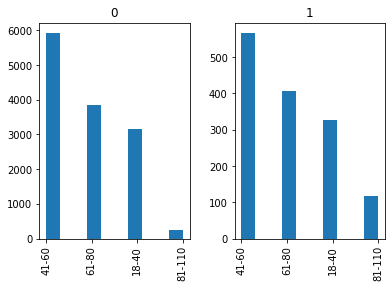

In [7]:
# 按照指定的区间进行分组
bins = [18, 40, 60, 80, 110]
labels = ['18-40', '41-60', '61-80', '81-110']
ALL_data['agegroup'] = pd.cut(ALL_data['age'], bins=bins, labels=labels)
ALL_data.hist('agegroup',by = 'label',sharex=True)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

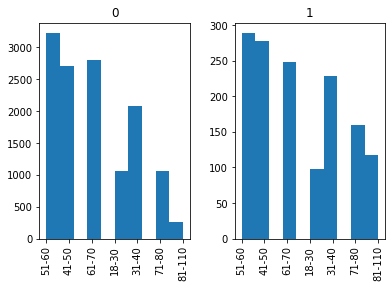

In [12]:
# 按照指定的区间进行分组
bins = [18, 30, 40, 50, 60, 70, 80,110]
labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71-80','81-110']
ALL_data['agegroup'] = pd.cut(ALL_data['age'], bins=bins, labels=labels)
ALL_data.hist(column='agegroup',by = 'label',sharex=True)

In [49]:
HTN_df = ALL_data[(ALL_data['label']==1) ].drop_duplicates(subset=['ID'],keep = 'first').copy()

In [19]:
from sklearn.model_selection import train_test_split
# 按照agerange和gender进行分层抽样

NHTN_df = ALL_data[(ALL_data['label']==0) ].drop_duplicates(subset=['ID'],keep = 'first').copy()
HTN_df = ALL_data[(ALL_data['label']==1) ].drop_duplicates(subset=['ID'],keep = 'first').copy()
TV_HTN_df, test_HTN_df = train_test_split(HTN_df, test_size=0.2, stratify=HTN_df[['agegroup', 'gender']])
test_ID_list = pair_HTN(test_HTN_df.drop_duplicates(['ID'],keep='first'),NHTN_df.drop_duplicates(['ID'],keep='first'),
                            Range_max=2,
                            pair_num=1,
                            shuffle=True)['ID'].tolist()#按照年龄和性别对每个ID号去配对 (先去除重复ID)
pair_index = ALL_data[[True if i in test_ID_list else False for i in ALL_data['ID']]].index
test_df = ALL_data.loc[pair_index].copy()
left_index = ALL_data[[False if i in test_ID_list else True for i in ALL_data['ID']]].index #不在test_ID_list的ID 即为tv的
TV_df = ALL_data.loc[left_index].copy()



TV_NHTN_df = TV_df[(TV_df['label']==0) ].drop_duplicates(subset=['ID'],keep = 'first').copy()
TV_HTN_df = TV_df[(TV_df['label']==1) ].drop_duplicates(subset=['ID'],keep = 'first').copy()
fold_len= float((TV_HTN_df.__len__())//5) #每一fold的HTN的长度
TV_HTN_buffer = TV_HTN_df.copy()

validat_HTN_df_subsets = []
for i in range(4):
    TV_HTN_buffer, subset = train_test_split(TV_HTN_buffer, test_size=fold_len/(TV_HTN_buffer.__len__()), stratify=TV_HTN_buffer[['agegroup', 'gender']])
    print(subset.__len__())
    validat_HTN_df_subsets.append(subset)
print(TV_HTN_buffer.__len__())
validat_HTN_df_subsets.append(TV_HTN_buffer)

validat_ID_list_subsets = []
for i in range(validat_HTN_df_subsets.__len__()):
    i_ID_list = pair_HTN(validat_HTN_df_subsets[i].drop_duplicates(['ID'],keep='first'),
                         TV_NHTN_df.drop_duplicates(['ID'],keep='first'),
                            Range_max=2,
                            pair_num=1,
                            shuffle=True)['ID'].tolist()#按照年龄和性别对每个ID号去配对 (先去除重复ID)
    validat_ID_list_subsets.append(i_ID_list)


lack sample like : Pandas(Index=176158, _1=173812, _2=173812, index=490, 序号=491, name='刘正坤', gender='女', age=92, 检查时间=nan, 申请部门=nan, 门诊号=nan, ID='480505', 急诊号=nan, 体检号=nan, 医嘱号=nan, 临床诊断='高血压病3级（极高危）', 诊断=nan, 特征=nan, 心率=nan, PR=179.0, RR=nan, QRS=93.0, QT=441.0, QTc=450.0, 电轴='-5.0', RV5=1.93, RV6=1.55, SV1=1.47, RS=3.4, 心律='窦性', 室率='62', 房率='62', P时限=103.0, _33=nan, _34=nan, _35=nan, _36=nan, _37=nan, _38=nan, _39=nan, _40=nan, _41=nan, _42=nan, 急诊号_1=nan, 出生日期='1926-11-14', year=0, ECGFilename='00-1-491', xmlPath='/workspace/data/Preprocess_HTN/00/00/HTN/xml/491.xml', Q=0.0, label=1, agegroup='81-110')
lack sample like : Pandas(Index=64857, _1=62408, _2=62408, index=22361, 序号=22362, name='潘世明', gender='男', age=97, 检查时间='2020-04-15 04:21:14', 申请部门='干部保健一科一区', 门诊号=nan, ID='807057', 急诊号=nan, 体检号=nan, 医嘱号=807057001.0, 临床诊断='高血压病3级（极高危）', 诊断='1.窦性心律\n2.心电轴左偏', 特征='PⅠ、Ⅱ直立，PavR倒置。\n心电轴<-30°', 心率=61.0, PR=197.0, RR=1004.0, QRS=102.0, QT=446.0, QTc=445.0, 电轴='-37', RV5=0.59, RV6=0.5, SV1=0.9

          Fold 0 of 5 :
lack sample like : Pandas(Index=69625, _1=67176, _2=67176, index=27129, 序号=27130, name='苏碧羡', gender='女', age=94, 检查时间='2020-08-31 12:37:40', 申请部门='中医科病房', 门诊号=nan, ID='280452', 急诊号=nan, 体检号=nan, 医嘱号=280452007.0, 临床诊断='高血压3级', 诊断='1.窦性心律\n2.室性早搏 \n3.T波改变', 特征='PⅠ、Ⅱ直立，PavR倒置。\n各导联见提前宽大畸形QRS波群≥0.12s，其前无相关P波，QRS主波与T波方向相反，代偿间歇完全。\nT：Ⅰ、aVL、Ⅱ、Ⅲ、aVF、V4、V5、V6 低平', 心率=71.0, PR=120.0, RR=874.0, QRS=96.0, QT=453.0, QTc=485.0, 电轴='46', RV5=1.16, RV6=0.7, SV1=0.58, RS=1.74, 心律='窦性', 室率='71', 房率='71', P时限=80.0, _33=71.0, _34=46.0, _35=34.0, _36=97.0, _37=96.0, _38=453.0, _39=494.0, _40=1.16, _41=0.58, _42=1.74, 急诊号_1=nan, 出生日期=nan, year=20, ECGFilename='20-27130', xmlPath='/workspace/data/Preprocess_HTN/2020/2020/27130/1.xml', Q=0.0, label=1, agegroup='81-110')
lack sample like : Pandas(Index=148146, _1=145713, _2=145713, index=12451, 序号=12452, name='李如绥', gender='男', age=95, 检查时间='2022-04-18 08:58:31', 申请部门='干部保健二科三区', 门诊号=nan, ID='297125', 急诊号=nan, 体检号=nan, 医嘱号=297125011.0,

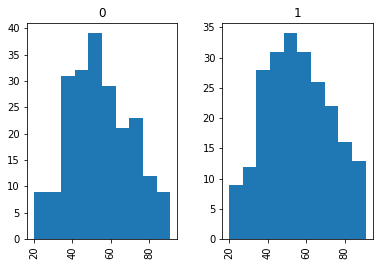

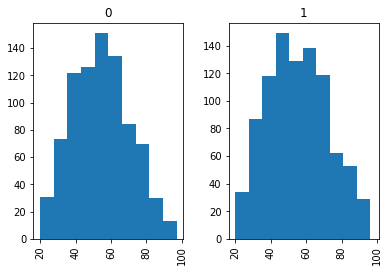

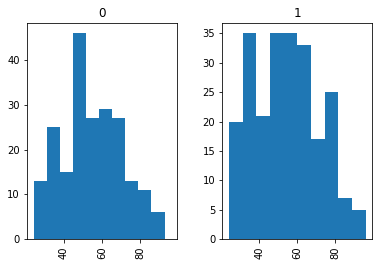

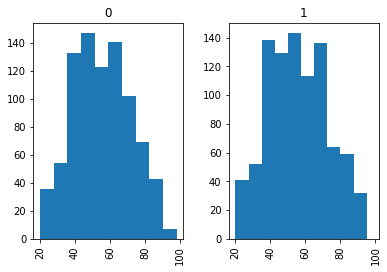

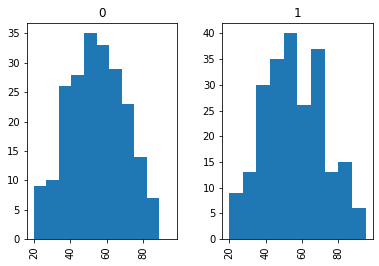

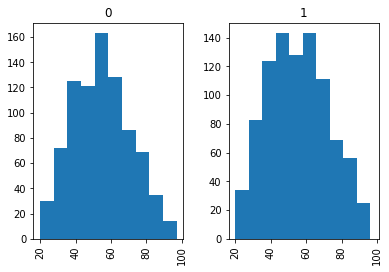

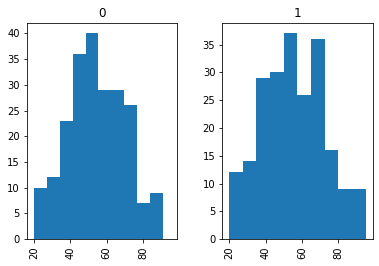

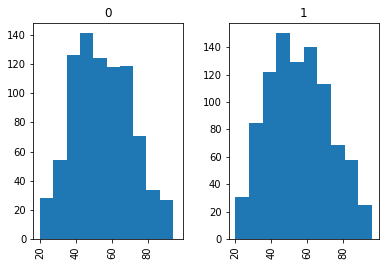

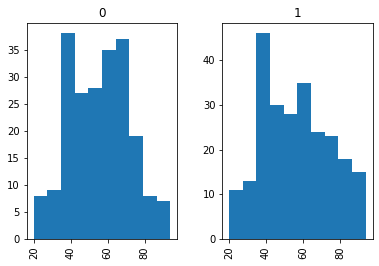

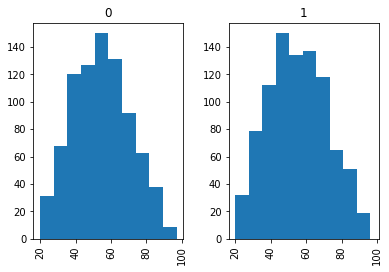

In [20]:
for fold in range(5):
    print(" "*10+ "Fold "+str(fold)+" of "+str(5) + ' :')

    pair_index = TV_df[[True if i in validat_ID_list_subsets[fold] else False for i in TV_df['ID']]].index
    validate_df = TV_df.loc[pair_index].copy()
    left_index = TV_df[[False if i in validat_ID_list_subsets[fold] else True for i in TV_df['ID']]].index #不在test_ID_list的ID 即为tv的
    train_df = TV_df.loc[left_index].copy()
    train_pair_df,_ = Pair_ID(train_df,1,star_index=0,Range_max=5,pair_num=1,shuffle=True)

    validate_df.hist('age',by = 'label',sharex=True)
    train_pair_df.hist('age',by = 'label',sharex=True)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

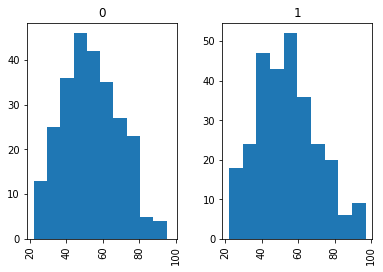

In [21]:
test_df.hist('age',by = 'label',sharex=True)

## plot

In [ ]:
jpg_path = './jpg/'
for index in range(test_dataset.__len__()):#test_dataset.__len__()
    info =test_dataset.infos.iloc[index]
    file_name = info['ECGFilename']
    ID = info['ID']
    date = info['检查时间']
    age = info['age']
    label = info['label']
    ECG,labels = test_dataset.__getitem__(index)
    ECG = ECG*5000 #恢复
    ecg_plot.plot(ECG*4.88/1000, sample_rate = 500, title = 'ID:'+str(ID)+' '+ 'label: '+ str(label) +' '+'Date: '+str(date)+' '+'age: '+str(age)  ,row_height= 10,show_grid=True,show_separate_line=True)
    ecg_plot.save_as_jpg(file_name,jpg_path)